In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

RANDOM_STATE = 123
np.random.seed(123)

## Load data

In [2]:
df_gym = pd.read_csv('data/modified_gym_members_exercise_tracking.csv')

In [3]:
df_heart_rates = pd.read_csv('data/gym_members_heart_rates.csv')

In [4]:
df_heart_rates.head()

,User_ID,Heart_Rate
0,0,114
1,0,133
2,0,136
3,0,134
4,0,131


In [5]:
df_heart_rates['User_ID'].unique().shape

(247,)

In [6]:
df_gym.shape

(247, 15)

## Energy calculation - Fuzzy Logic

### Fuzzy controller

In [7]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [ ]:
class FuzzyController:
    def __init__(self):
        self.bpm_antecedent = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'Normalized BPM')
        self.bpm_variation_antecedent = ctrl.Antecedent(np.arange(-0.2, 0.21, 0.01), 'Normalized BPM Variation')
        self.energy_consequent = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'Energy')

        self.bpm_antecedent['Very Light'] = fuzz.trapmf(self.bpm_antecedent.universe, [0.00, 0.00, 0.54, 0.60])
        self.bpm_antecedent['Light'] = fuzz.trapmf(self.bpm_antecedent.universe, [0.54, 0.60, 0.61, 0.67])
        self.bpm_antecedent['Moderate'] = fuzz.trapmf(self.bpm_antecedent.universe, [0.61, 0.67, 0.74, 0.80])
        self.bpm_antecedent['Vigorous'] = fuzz.trapmf(self.bpm_antecedent.universe, [0.74, 0.80, 0.93, 0.99])
        self.bpm_antecedent['Near Maximal'] = fuzz.trapmf(self.bpm_antecedent.universe, [0.93, 0.99, 1.00, 1.00])

        self.bpm_variation_antecedent['Negative'] = fuzz.trapmf(self.bpm_variation_antecedent.universe, [-0.2, -0.2, -0.15, -0.05])
        self.bpm_variation_antecedent['Zero'] = fuzz.trapmf(self.bpm_variation_antecedent.universe, [-0.15, -0.05, 0.05, 0.15])
        self.bpm_variation_antecedent['Positive'] = fuzz.trapmf(self.bpm_variation_antecedent.universe, [0.05, 0.15, 0.2, 0.21])

        self.energy_consequent['Low'] = fuzz.trapmf(self.energy_consequent.universe, [0.0, 0.0, 0.0, 0.5])
        self.energy_consequent['Medium'] = fuzz.trapmf(self.energy_consequent.universe, [0.25, 0.5, 0.5, 0.75])
        self.energy_consequent['High'] = fuzz.trapmf(self.energy_consequent.universe, [0.5, 1, 1.0, 1.0])

        self.energy_consequent.defuzzify_method = 'centroid'

        # Rules:
        # Rule Intensity_zone Variation ⇒ Energy
        # R1 Very_Light – ⇒ High
        # R1 Light Negative ⇒ High
        # R1 Light Zero ⇒ High
        # R1 Moderate Negative ⇒ High

        # R2 Light Positive ⇒ Medium
        # R2 Moderate Zero ⇒ Medium
        # R2 Moderate Positive ⇒ Medium
        # R2 Vigorous Negative ⇒ Medium
        # R2 Vigorous Zero ⇒ Medium

        # R3 Near_maximal – ⇒ Low
        # R3 Vigorous Positive ⇒ Low

        rule1 = ctrl.Rule(antecedent= (self.bpm_antecedent['Very Light'] |
                        (self.bpm_antecedent['Light'] & self.bpm_variation_antecedent['Negative']) |
                        (self.bpm_antecedent['Light'] & self.bpm_variation_antecedent['Zero']) |
                        (self.bpm_antecedent['Moderate'] & self.bpm_variation_antecedent['Negative'])),
                        consequent=self.energy_consequent['High'])
        
        rule2 = ctrl.Rule(antecedent=((self.bpm_antecedent['Light'] & self.bpm_variation_antecedent['Positive']) |
                                (self.bpm_antecedent['Moderate'] & self.bpm_variation_antecedent['Zero']) |
                                (self.bpm_antecedent['Moderate'] & self.bpm_variation_antecedent['Positive']) |
                                (self.bpm_antecedent['Vigorous'] & self.bpm_variation_antecedent['Negative'])) |
                                (self.bpm_antecedent['Vigorous'] & self.bpm_variation_antecedent['Zero']),
                                consequent=self.energy_consequent['Medium'])
        
        rule3 = ctrl.Rule(antecedent=(self.bpm_antecedent['Near Maximal'] |
                        (self.bpm_antecedent['Vigorous'] & self.bpm_variation_antecedent['Positive'])),
                        consequent=self.energy_consequent['Low'])

        energy_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
        self.energy_sim = ctrl.ControlSystemSimulation(energy_ctrl)

    def calculate_energy(self, bpm, bpm_variation, age, plot_consequent=False, plot_antecedent=False):
        hr_max = 208 - 0.7 * age # Paper: Age-Predicted Maximal Heart Rate Revisited

        bpm_normalized = bpm  / hr_max
        bpm_variation_normalized = bpm_variation / hr_max

        self.energy_sim.input['Normalized BPM'] = bpm_normalized
        self.energy_sim.input['Normalized BPM Variation'] = bpm_variation_normalized
        self.energy_sim.compute()

        
        if plot_consequent:
            self.energy_consequent.view(sim=self.energy_sim)
        if plot_antecedent:
            self.bpm_antecedent.view(sim=self.energy_sim)
            self.bpm_variation_antecedent.view(sim=self.energy_sim)
        
        return self.energy_sim.output['Energy']

    def view_bpm_antecedent(self):
        self.bpm_antecedent.view()
    
    def view_bpm_variation_antecedent(self):
        self.bpm_variation_antecedent.view()

    def view_energy_consequent(self):
        self.energy_consequent.view()


c:\Users\danih\anaconda3\envs\MasterIA\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


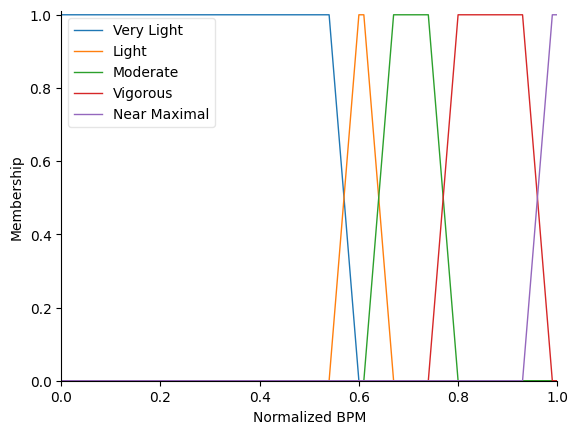

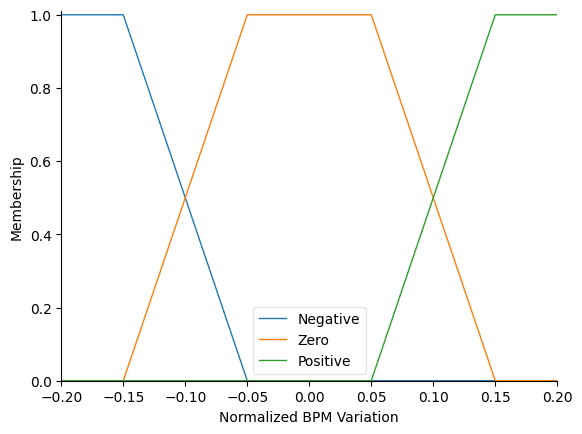

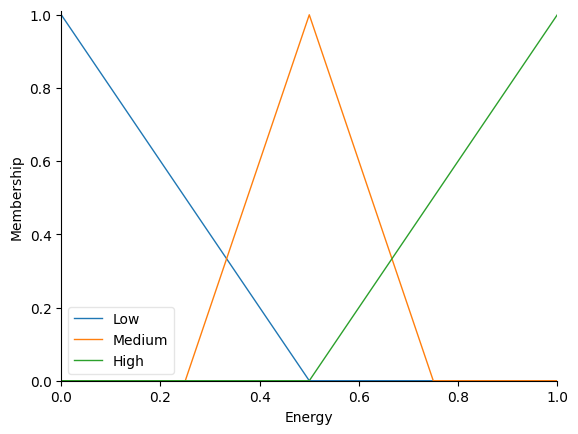

In [9]:
fuzzy_controller = FuzzyController()
fuzzy_controller.view_bpm_antecedent()
fuzzy_controller.view_bpm_variation_antecedent()
fuzzy_controller.view_energy_consequent()

#### Example

np.float64(0.7452918132221183)

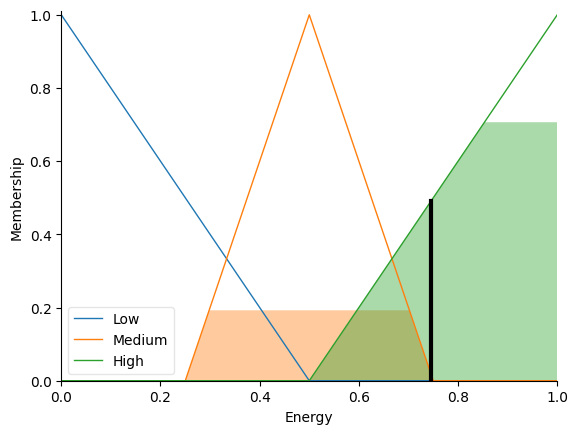

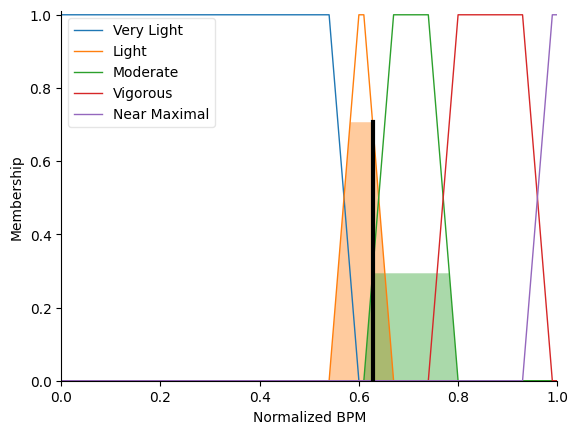

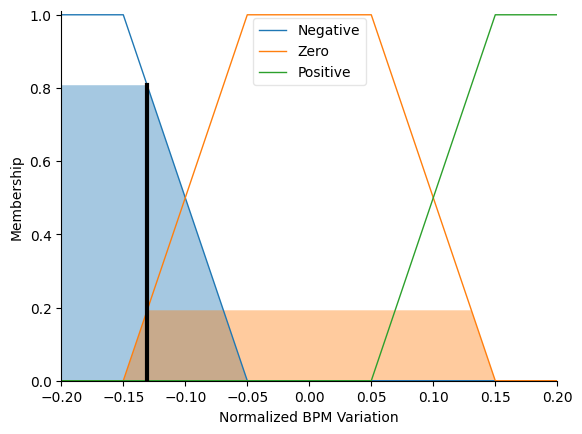

In [10]:
bpm = 120
bpm_variation = -25
fuzzy_controller.calculate_energy(bpm, bpm_variation, 24, plot_consequent=True, plot_antecedent=True)

### Energy Calculator Model

In [11]:
class EnergyCalculator:
    def __init__(self, df_gym_member, df_heart_rates, fuzzy_controller=None):
        self.user_age = df_gym_member['Age']
        self.df_heart_rates = df_heart_rates
        self.sesion_minute = 0
        if fuzzy_controller is None:
            self.fuzzy_controller = FuzzyController()
        else:
            self.fuzzy_controller = fuzzy_controller

    def calculate_energy(self, plot_consequent=False, plot_antecedent=False):
        if self.sesion_minute == 0:
            return 0.6 # Default energy for the first song
        if self.sesion_minute >= len(self.df_heart_rates):
            return -1 # Indicates that the session has ended
        bpm_current = self.df_heart_rates[self.sesion_minute]
        bpm_variation = bpm_current - self.df_heart_rates[self.sesion_minute - 1]
        print(f"Calculating energy for session minute {self.sesion_minute}")
        print(f"Previous BPM: {self.df_heart_rates[self.sesion_minute - 1]}, Current BPM: {bpm_current}, BPM Variation: {bpm_variation}")
        return self.fuzzy_controller.calculate_energy(self.df_heart_rates[self.sesion_minute], bpm_variation, self.user_age, plot_consequent, plot_antecedent)
    
    def pass_song_duration(self, song_duration=2): # Song duration in minutes
        self.sesion_minute += song_duration
        if self.sesion_minute >= len(self.df_heart_rates):
            return -1
        return self.sesion_minute
    
    def get_session_minute(self):
        return self.sesion_minute

    def view_bpm_antecedent(self):
        self.fuzzy_controller.view_bpm_antecedent()
    
    def view_bpm_variation_antecedent(self):
        self.fuzzy_controller.view_bpm_variation_antecedent()
    
    def view_energy_consequent(self):
        self.fuzzy_controller.view_energy_consequent()

#### Example

In [35]:
df_gym.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
1,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
2,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
3,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07
4,57,Male,112.5,1.61,195,165,61,1.24,1013.0,Cardio,22.1,2.7,3,2,43.40


In [64]:
client_used = 2
client_heart_rates = df_heart_rates[df_heart_rates['User_ID'] == client_used]['Heart_Rate'].tolist()

In [65]:
energy_calculator = EnergyCalculator(df_gym.iloc[client_used], client_heart_rates)

In [66]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=False, plot_antecedent=False)}")
energy_calculator.pass_song_duration(3) # We assume the song duration is 3 minutes

Energy level 0.6


3

Calculating energy for session minute 3
Previous BPM: 126, Current BPM: 119, BPM Variation: -7
Energy level 0.5511713794454283


7

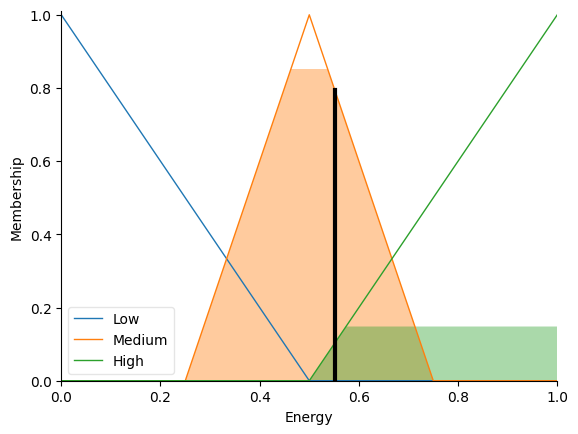

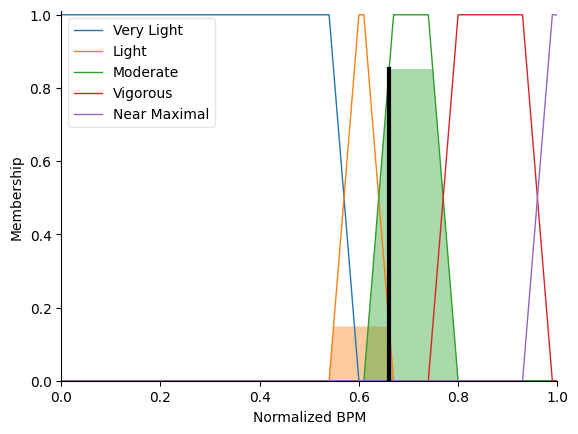

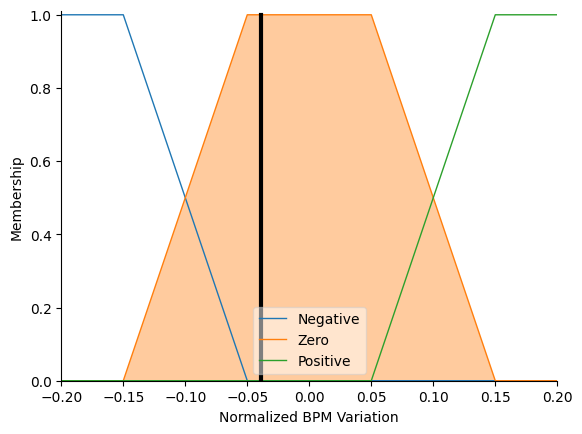

In [67]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=True, plot_antecedent=True)}")
energy_calculator.pass_song_duration(4) # We assume the song duration is 4 minutes

In [68]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=False, plot_antecedent=False)}")
energy_calculator.pass_song_duration(3) # We assume the song duration is 3 minutes

Calculating energy for session minute 7
Previous BPM: 130, Current BPM: 116, BPM Variation: -14
Energy level 0.6338102220009258


10

In [69]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=False, plot_antecedent=False)}")
energy_calculator.pass_song_duration(5) # We assume the song duration is 5 minutes

Calculating energy for session minute 10
Previous BPM: 105, Current BPM: 109, BPM Variation: 4
Energy level 0.8333333333333334


15